# Sistema CSTR

Este cuaderno se estudia el sistema discutido en Seborg, Edgar, Melichamp & Doyle "Process Dynamics and Control" (3rd Ed).

![CSTR](cstr.png)

## Modelo

$$
\begin{align}
k &= k_0\exp\left(\frac{-E}{RT}\right)\\
w &=q\rho \\
V\frac{\mathrm{d}c_A}{\mathrm{d}t} &= q(c_{Ai} - c_A) - V k c_A \\
V\rho C\frac{\mathrm{d}T}{\mathrm{d}t} &= wC(T_i - T) + (-\Delta H_R) V k c_A + UA(T_c - T)
\end{align}
$$

Balance de Energía:

$$\frac{dE}{dt} = E_{in} - E_{out}$$

Balance de Masa:

$$\frac{dm}{dt} = \dot m_{in} - \dot m_{out}$$

Balance de composición:

$$\frac{dN_A}{dt} = N_{A,in} - N_{A, out} + N_{A, \text{gen}} - N_{A, \text{consumed}}$$

## Simulación numérica del sistema

In [1]:
import numpy as np
import scipy as sc
import scipy.optimize as opt
import scipy.integrate as inte

Valores de los parámetros del modelo

In [2]:
q = 100  # L/min
cA_i = 1  # mol/L
T_i = 350  # K 
V = 100  # L
rho = 1000 # g/L
C = 0.239 # J/(g K)
Hr = -5e4  # J/(g K)
E_over_R = 8750  # K
k0 = 7.2e10  # 1/min
UA = 5e4  # J/(min K)

Este es el valor inicial de la entrada $T_c$

In [3]:
Tc = Tc0 = 300  # K

Estos son los valores iniciales de los estados. Tenga en cuenta que estos no son 100% exactos. Cuando usando estos estos valores, no obtenemos una línea recta perfecta (derivadas iguales a cero) como deberíamos al usar los valores de estado estacionario (completamente estacionado).

In [4]:
cA0 = 0.5  # mol/L
T0 = 350  # K 

Aquí definimos la función para calcular las derivadas.

In [5]:
def intsys(t, x):
    cA, T = x
    k = k0*np.exp(-E_over_R/T)
    w = q*rho
    dcAdt = q*(cA_i - cA)/V - k*cA
    dTdt = 1/(V*rho*C)*(w*C*(T_i - T) - Hr*V*k*cA + UA*(Tc - T))
    return dcAdt, dTdt

In [6]:
x0 = [cA0, T0]

Veamos cómo se ven las derivadas en este "estado estacionario"

In [7]:
intsys(0, x0)

(3.40208612952253e-05, -0.007117334999003795)

Eso no parece muy cerca de cero ...

Ahora, simulemos

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
tspan = (0, 10)
t = np.linspace(*tspan, 1000)

In [10]:
def simulate():
    r = inte.solve_ivp(intsys, tspan, x0, t_eval=t)
    return r.y

In [11]:
cA, T = simulate()

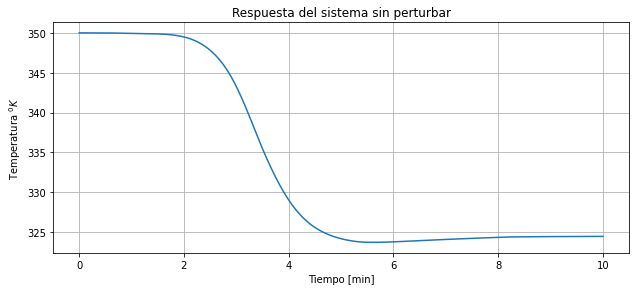

In [12]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,T, label=r'Temperatura')
ax.set_title('Respuesta del sistema sin perturbar')
ax.set_xlabel('Tiempo [min]')
ax.set_ylabel('Temperatura $^0K$')
ax.grid();

¡Vemos una desviación significativa de la línea recta que esperábamos!

## Resolver el estado estacionario estable

Ahora, resolvamos un mejor valor inicial estableciendo los derivados igual a cero

In [13]:
def ss(x):
    """ This wrapper function simply calls intsys with a zero time"""
    return intsys(0, x)

Usamos `fsolve` para resolver un nuevo estado estacionario.

In [14]:
x0 = opt.fsolve(ss, x0)
x0

array([  0.49991829, 350.00552869])

Vamos a comprobar que:

In [15]:
ss(x0)

(3.7614356074300304e-13, -7.879222786077396e-11)

Mucho mejor, simulemos:

In [16]:
cA, T = simulate()

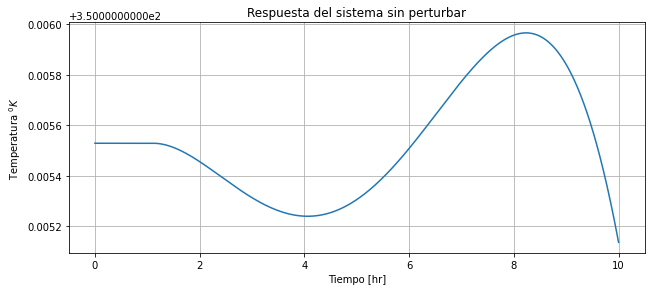

In [17]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,T, label='Temperatura')
ax.set_title('Respuesta del sistema sin perturbar')
ax.set_xlabel('Tiempo [hr]')
ax.set_ylabel('Temperatura $^0K$')
ax.grid();

¿Que paso ahi? Parece que estas ecuaciones son bastante difíciles de equilibrar perfectamente en el estado estacionario, ya que al iniciarse bastante cerca de cero, las derivadas aún dieron alguna desviación hacia el final. Las ecuaciones diferenciales no lineales a menudo exhiben esta alta sensibilidad al valor inicial.

Pero mira detenidamente y podrás ver que el eje está extrañamente indicado. Cuando nos alejamos un poco, la solución es más clara:

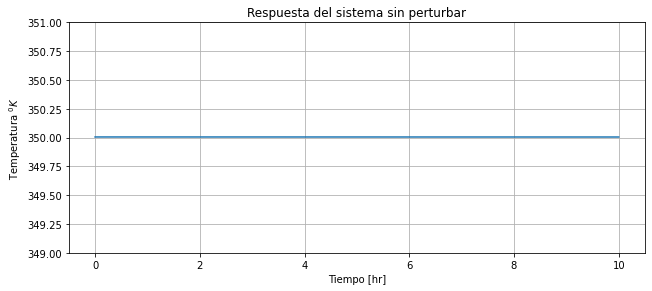

In [18]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(t,T, label='Temperatura')
ax.set_title('Respuesta del sistema sin perturbar')
ax.set_xlabel('Tiempo [hr]')
ax.set_ylabel('Temperatura $^0K$')
ax.set_ylim([349, 351])
ax.grid();

Yo diría que eso es lo suficientemente bueno.

Ahora estamos listos para crear la figura.

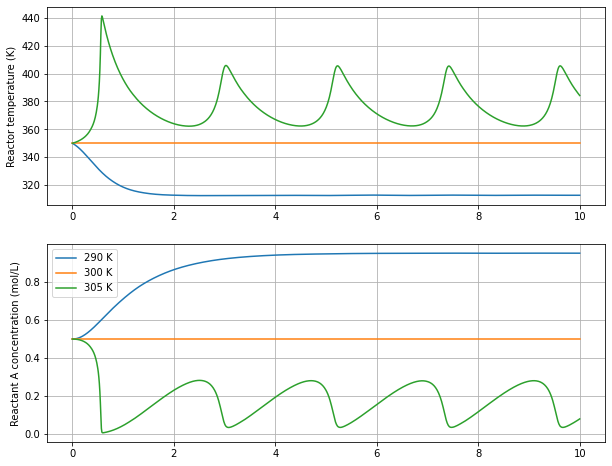

In [19]:
fig, (axT, axcA) = plt.subplots(2, 1, figsize=(10, 8))
for Tc in [290, 300, 305]:
    cA, T = simulate()
    axT.plot(t, T, label='{} K'.format(Tc))
    axT.set_ylabel('Reactor temperature (K)')
    axT.grid()
    axcA.plot(t, cA, label='{} K'.format(Tc))    
    axcA.set_ylabel('Reactant A concentration (mol/L)')
    axcA.grid()
axcA.legend()
plt.show()

## Comportamiento no lineal

Las ecuaciones diferenciales no lineales como esta pueden exhibir un comportamiento muy extraño. Podemos esperar que el aumento de la temperatura del agua de enfriamiento siempre incremente la temperatura del reactor, medida después de un cierto tiempo, pero el comportamiento oscilatorio que vemos en los gráficos anteriores nos da una pista de que no todo es tan simple.

In [20]:
sol = inte.solve_ivp(intsys, tspan, x0)

In [21]:
Tends = []
Tcs = np.linspace(300, 310, 100)
for Tc in Tcs:
    sol = inte.solve_ivp(intsys, tspan, x0)
    T = sol.y[-1]
    Tends.append(T[-1])

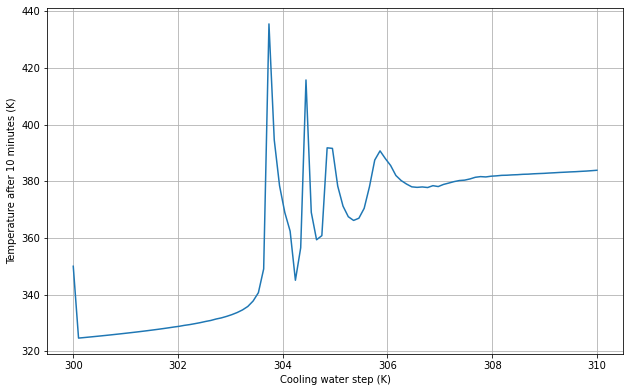

In [22]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(Tcs,Tends, label='Temperatura')
ax.set_xlabel('Cooling water step (K)')
ax.set_ylabel('Temperature after 10 minutes (K)')
ax.grid();

Se puede ver que a menudo no hay una explicación fácil para el comportamiento del sistema, como puede ser "Hacer que x sea más grande hará que y sea más grande". Para sistemas no lineales, la respuesta a las preguntas sobre la consecuencia de una acción es a menudo "depende".